# Plot results using the DataFrame stored in pickle file

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os
from pandas.io.json import json_normalize
import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options

#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

In [2]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('EWino_scan1.pcl')
#print(dataDF.columns.values.tolist()) #Print all columns names

#### Set r = 0 for points with no results 

In [3]:
#Set points without results with r == 0
dataDF.fillna(value={'ExptRes.result0.r' : 0.0},inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)
#Add simple flag for excluded points:
dataDF['excluded'] = dataDF['ExptRes.result0.r'] > 1.

#### Add c*tau column for charginos

In [4]:
dataDF['ctau.1000024'] = 1.967e-16/dataDF['width.1000024']

### Get points excluded:

In [5]:
excluded = dataDF[dataDF['excluded'] == True]
allowed = dataDF[dataDF['excluded'] == False]
print('Total number of points = %i' %len(dataDF))
print('Total excluded = %i'%(len(excluded)))
print('Total allowed = %i'%(len(allowed)))

Total number of points = 57265
Total excluded = 448
Total allowed = 56817


#### Plot distribution excluded points

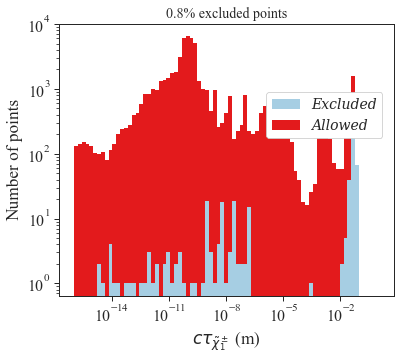

In [6]:
plt.figure(figsize=(6,5))
xExcluded = excluded['ctau.1000024']
xAllowed = allowed['ctau.1000024']
nbins = np.logspace(-16,0,80)
colors = np.take(sns.color_palette("Paired"),[0,5],axis=0)
plt.hist([xExcluded,xAllowed],nbins,stacked=True, 
                            histtype='barstacked', label=['Excluded','Allowed'],
                            linewidth=0, fill=True, color=colors)
lgd = plt.legend(bbox_to_anchor=(0.62, 0.75), loc=2, borderaxespad=0.,
                 prop={'family' :'serif','style' : 'italic', 'size' : 14},framealpha=1.)
plt.yscale('log')
plt.xscale('log')
plt.title('%1.1f%% excluded points' %(100*len(excluded)/float(len(dataDF))), fontsize=14)
plt.xlabel(r'$c \tau_{\tilde{\chi}_1^\pm}$ (m)')
plt.ylabel('Number of points')
plt.show()

### Plot excluded points grouped by most excluding analysis

ATLAS-SUSY-2016-06    323
CMS-SUS-17-004        105
ATLAS-SUSY-2019-08     12
ATLAS-SUSY-2018-32      4
ATLAS-SUSY-2013-12      3
ATLAS-SUSY-2016-32      1
Name: ExptRes.result0.AnalysisID, dtype: int64


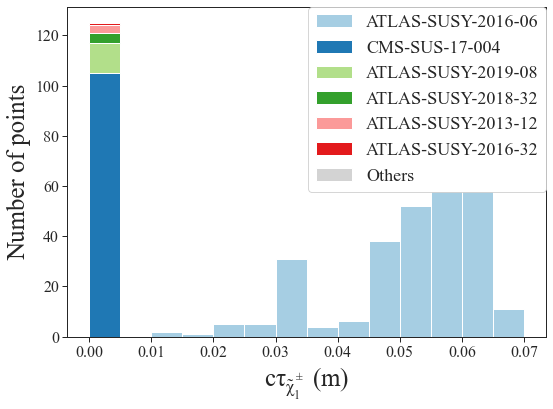

In [7]:
anas = excluded['ExptRes.result0.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)
print(anas)

plt.figure(figsize=(8,6))

# nbins = np.logspace(-3,3,20)
nbins=np.linspace(0,0.07,15)
colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
c_other = 'lightgray'
first = True
labels= []
hists = []
colors = []
xothers = []
for i,ana in enumerate(anas.index):
    x = excluded[excluded['ExptRes.result0.AnalysisID'] == ana]['ctau.1000024']
    if anas[ana] < 0:
        xothers += x.tolist()        
        continue
    else:
        color = colorDict[ana]
        label = ana
    
    hists.append(x)
    colors.append(color)
    labels.append(label)

hists.append(xothers)
labels.append('Others')
colors.append(c_other)
plt.hist(hists,nbins,color=colors,label=labels,
                            histtype='barstacked',
                            linewidth=1, fill=True)

lgd = plt.legend(loc='upper right', borderaxespad=0.,framealpha=1.,fontsize=18)

# plt.ylim(0,6500)
# plt.xlim(0,0.07)
# plt.title('SModelS v2.0', fontsize=26)
plt.xlabel(r'$\mathregular{c \tau_{\tilde{\chi}_1^\pm}}$ (m)',fontsize = 25)
plt.ylabel('Number of points',fontsize = 25)
plt.tight_layout()
plt.savefig('Wino_v2.png')
plt.show()

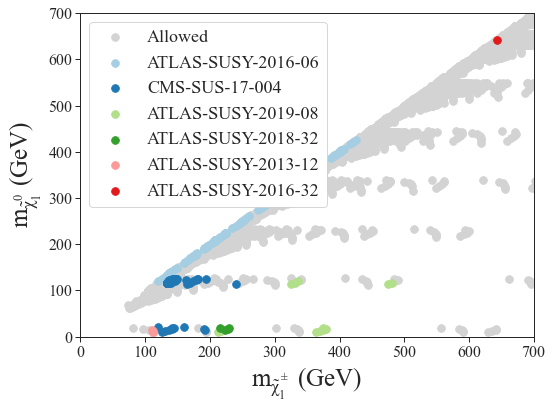

In [8]:
anas = excluded['ExptRes.result0.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)

plt.figure(figsize=(8,6))

# nbins = np.logspace(-3,3,20)
nbins=np.linspace(0,0.07,15)
colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
c_other = 'lightgray'


x = allowed['mass.1000024']
y = allowed['mass.1000022']
plt.scatter(x,y,color=c_other,label='Allowed',s=60)
for i,ana in enumerate(anas.index):
    x = excluded[excluded['ExptRes.result0.AnalysisID'] == ana]['mass.1000024']
    y = excluded[excluded['ExptRes.result0.AnalysisID'] == ana]['mass.1000022']
    color = colorDict[ana]
    label = ana
    plt.scatter(x,y,color=color,label=label,s=60)


lgd = plt.legend(loc='upper left', framealpha=1.,fontsize=18)

plt.ylim(0,700)
plt.xlim(0,700)
plt.xlabel(r'$\mathregular{m_{\tilde{\chi}_1^\pm}}$ (GeV)',fontsize = 25)
plt.ylabel(r'$\mathregular{m_{\tilde{\chi}_1^0}}$ (GeV)',fontsize = 25)
plt.tight_layout()
plt.show()

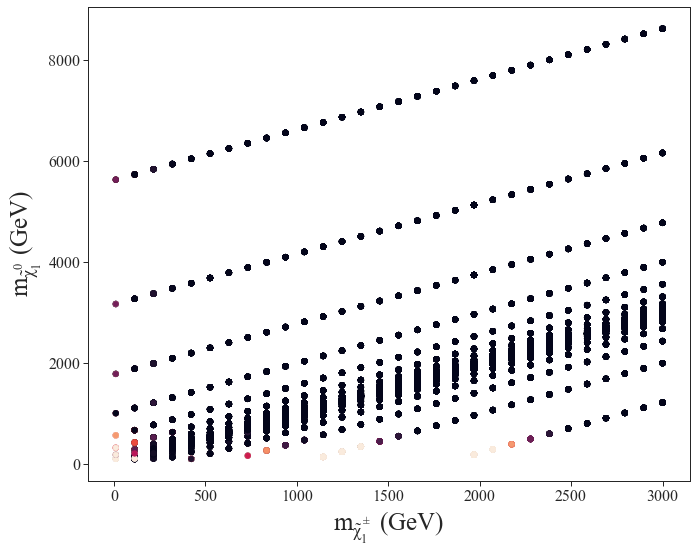

In [9]:
plt.figure(figsize=(10,8))

x = dataDF['extpar.1']
y = dataDF['extpar.2']
z = dataDF['ExptRes.result0.r']
x = x[z.argsort()]
y = y[z.argsort()]
z = z[z.argsort()]
plt.scatter(x,y,c=z,s=30,vmin=0,vmax=1)

# plt.ylim(0,700)
# plt.xlim(0,700)
plt.xlabel(r'$\mathregular{m_{\tilde{\chi}_1^\pm}}$ (GeV)',fontsize = 25)
plt.ylabel(r'$\mathregular{m_{\tilde{\chi}_1^0}}$ (GeV)',fontsize = 25)
plt.tight_layout()
plt.show()

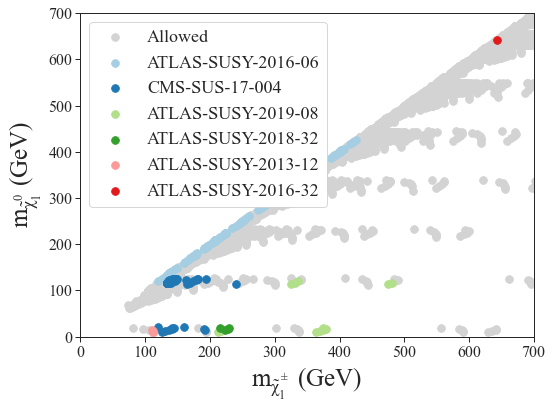

In [10]:
plt.figure(figsize=(8,6))

# nbins = np.logspace(-3,3,20)
nbins=np.linspace(0,0.07,15)
colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
c_other = 'lightgray'


x = allowed['mass.1000024']
y = allowed['mass.1000022']
plt.scatter(x,y,color=c_other,label='Allowed',s=60)
for i,ana in enumerate(anas.index):
    x = excluded[excluded['ExptRes.result0.AnalysisID'] == ana]['mass.1000024']
    y = excluded[excluded['ExptRes.result0.AnalysisID'] == ana]['mass.1000022']
    color = colorDict[ana]
    label = ana
    plt.scatter(x,y,color=color,label=label,s=60)


lgd = plt.legend(loc='upper left', framealpha=1.,fontsize=18)

plt.ylim(0,700)
plt.xlim(0,700)
plt.xlabel(r'$\mathregular{m_{\tilde{\chi}_1^\pm}}$ (GeV)',fontsize = 25)
plt.ylabel(r'$\mathregular{m_{\tilde{\chi}_1^0}}$ (GeV)',fontsize = 25)
plt.tight_layout()
plt.show()

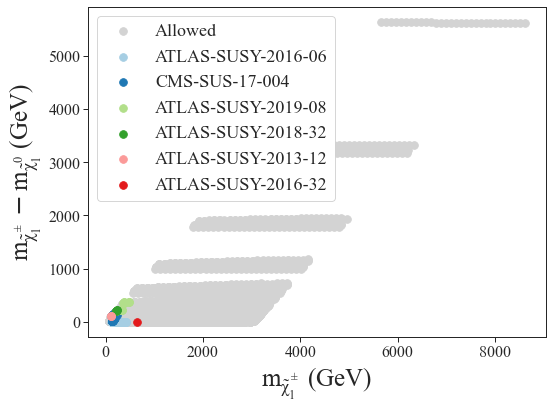

In [11]:
anas = excluded['ExptRes.result0.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)

plt.figure(figsize=(8,6))

# nbins = np.logspace(-3,3,20)
nbins=np.linspace(0,0.07,15)
colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
c_other = 'lightgray'


x = allowed['mass.1000024']
y = allowed['mass.1000022']
y = x-y
plt.scatter(x,y,color=c_other,label='Allowed',s=60)
for i,ana in enumerate(anas.index):
    x = excluded[excluded['ExptRes.result0.AnalysisID'] == ana]['mass.1000024']
    y = excluded[excluded['ExptRes.result0.AnalysisID'] == ana]['mass.1000022']
    y = x-y
    color = colorDict[ana]
    label = ana
    plt.scatter(x,y,color=color,label=label,s=60)


lgd = plt.legend(loc='upper left', framealpha=1.,fontsize=18)

# plt.ylim(0,6500)
# plt.xlim(0,400)
# plt.ylim(0,400)
plt.ylabel(r'$\mathregular{m_{\tilde{\chi}_1^\pm}}-\mathregular{m_{\tilde{\chi}_1^0}}$ (GeV)',fontsize = 25)
plt.xlabel(r'$\mathregular{m_{\tilde{\chi}_1^\pm}}$ (GeV)',fontsize = 25)
plt.tight_layout()
plt.show()

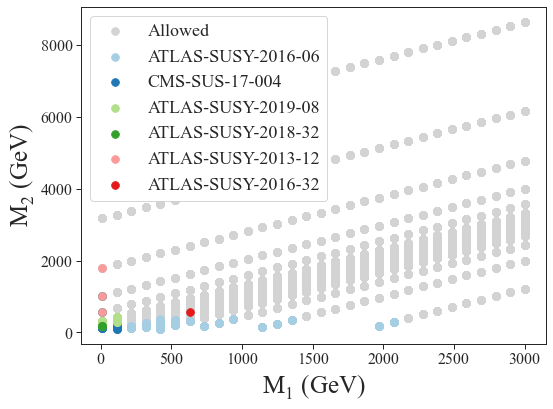

In [12]:
anas = excluded['ExptRes.result0.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)

plt.figure(figsize=(8,6))

# nbins = np.logspace(-3,3,20)
nbins=np.linspace(0,0.07,15)
colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
c_other = 'lightgray'


x = allowed['extpar.1']
y = allowed['extpar.2']
plt.scatter(x,y,color=c_other,label='Allowed',s=60)
for i,ana in enumerate(anas.index):
    x = excluded[excluded['ExptRes.result0.AnalysisID'] == ana]['extpar.1']
    y = excluded[excluded['ExptRes.result0.AnalysisID'] == ana]['extpar.2']
    color = colorDict[ana]
    label = ana
    plt.scatter(x,y,color=color,label=label,s=60)


lgd = plt.legend(loc='upper left', framealpha=1.,fontsize=18)

# plt.ylim(0,6500)
# plt.xlim(0,400)
# plt.ylim(0,400)
plt.ylabel(r'$\mathregular{M_2}$ (GeV)',fontsize = 25)
plt.xlabel(r'$\mathregular{M_1}$ (GeV)',fontsize = 25)
plt.tight_layout()
plt.show()

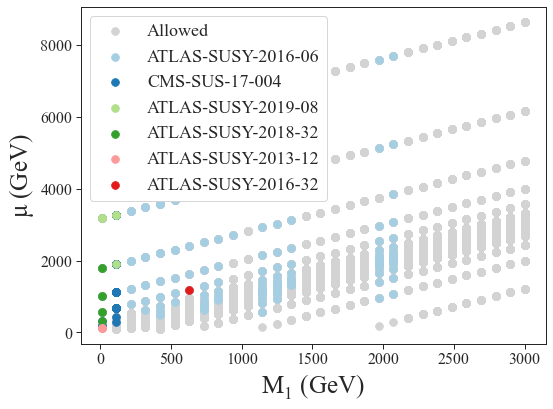

In [13]:
anas = excluded['ExptRes.result0.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)

plt.figure(figsize=(8,6))

# nbins = np.logspace(-3,3,20)
nbins=np.linspace(0,0.07,15)
colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
c_other = 'lightgray'


x = allowed['extpar.1']
y = allowed['extpar.23']
plt.scatter(x,y,color=c_other,label='Allowed',s=60)
for i,ana in enumerate(anas.index):
    x = excluded[excluded['ExptRes.result0.AnalysisID'] == ana]['extpar.1']
    y = excluded[excluded['ExptRes.result0.AnalysisID'] == ana]['extpar.23']
    color = colorDict[ana]
    label = ana
    plt.scatter(x,y,color=color,label=label,s=60)


lgd = plt.legend(loc='upper left', framealpha=1.,fontsize=18)

# plt.ylim(0,6500)
# plt.xlim(0,400)
# plt.ylim(0,400)
plt.ylabel(r'$\mathregular{\mu}$ (GeV)',fontsize = 25)
plt.xlabel(r'$\mathregular{M_1}$ (GeV)',fontsize = 25)
plt.tight_layout()
plt.show()